In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model import RidgeRegression
from selection import KFoldCV

## Una volta fatte le elaborazioni necessarie procediamo a fare il training

In [2]:
data = pd.read_pickle("./elaborated.pkl")

In [3]:
def quadratic_loss(y_true, y_pred):
    return (y_true-y_pred)**2

folds = 5
kfolds = KFoldCV(folds)
alfas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-3, 1e-2, 1, 5, 10, 20]
ridge = RidgeRegression(alfa=20)

In [4]:
errors = kfolds.cross_validate(ridge, data, "median_house_value", quadratic_loss)
errors

Scaled error: 0.3396101726585715
R2: 0.6951007885855249
MAE: 0.4628760049008127
MSE: 0.33967944551377927


Scaled error: 0.2638307730922857
R2: 0.5638816186774669
MAE: 0.3983243641964975
MSE: 0.26388458865028486


Scaled error: 0.2749928451841993
R2: 0.6814169605685412
MAE: 0.3900282619770447
MSE: 0.27504893755445636


Scaled error: 0.3307028827419799
R2: 0.632688602086092
MAE: 0.4503677577190394
MSE: 0.33077033870990286


Scaled error: 0.24656161606157598
R2: 0.7696696198927482
MAE: 0.3724292604866575
MSE: 0.24636064887578965




[0.3396101726585715,
 0.2638307730922857,
 0.2749928451841993,
 0.3307028827419799,
 0.24656161606157598]

Calcoliamo quindi la stima di errore della CV facendo la media degli errori scalati

In [5]:
CV_estimate = 1/folds * sum(errors)
CV_estimate

0.2911396579477225

In [29]:
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,median_house_value
0,-1.327803,1.062431,0.982119,-1.129227,-1.634187,-1.691975,-1.561273,1.858741,1.077249,-0.388000,-1.407363,-0.891134,-0.681873,2.830673,-0.384872,0.267459
1,-1.322812,1.053518,-0.607004,1.648799,1.312839,1.028436,1.440819,1.852658,0.665970,-1.095945,-1.156929,-0.891134,-0.681873,2.830673,-0.384872,0.200991
2,-1.332794,1.049060,1.856137,-0.449216,-1.103109,-1.106991,-1.097651,1.567092,1.700529,-0.047591,-1.916579,-0.891134,-0.681873,2.830673,-0.384872,0.195854
3,-1.337785,1.049060,1.856137,-0.636909,-0.811572,-0.947507,-0.807199,1.032541,0.411698,-0.399017,-0.462549,-0.891134,-0.681873,2.830673,-0.384872,0.186970
4,-1.337785,1.049060,1.856137,-0.311474,-0.571272,-0.930626,-0.578358,0.218039,0.691397,-0.972628,-0.747797,-0.891134,-0.681873,2.830673,-0.384872,0.187721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-0.758808,1.760643,-0.289180,-0.280754,-0.174256,-0.385606,-0.247879,-1.698888,-0.106621,-0.380708,0.347513,-0.891134,1.466479,-0.353256,-0.384872,-0.233597
20636,-0.818702,1.764917,-0.845373,-1.439441,-1.427326,-1.556056,-1.697800,-0.649541,0.592807,0.352472,0.171421,-0.891134,1.466479,-0.353256,-0.384872,-0.237272
20637,-0.823693,1.739256,-0.924829,0.122262,0.182199,-0.148113,0.122679,-1.516694,0.007109,-0.736241,0.170752,-0.891134,1.466479,-0.353256,-0.384872,-0.185958
20638,-0.873605,1.739256,-0.845373,-0.133387,-0.051559,-0.563441,-0.171517,-1.317372,0.092802,-1.072616,0.259964,-0.891134,1.466479,-0.353256,-0.384872,-0.210462


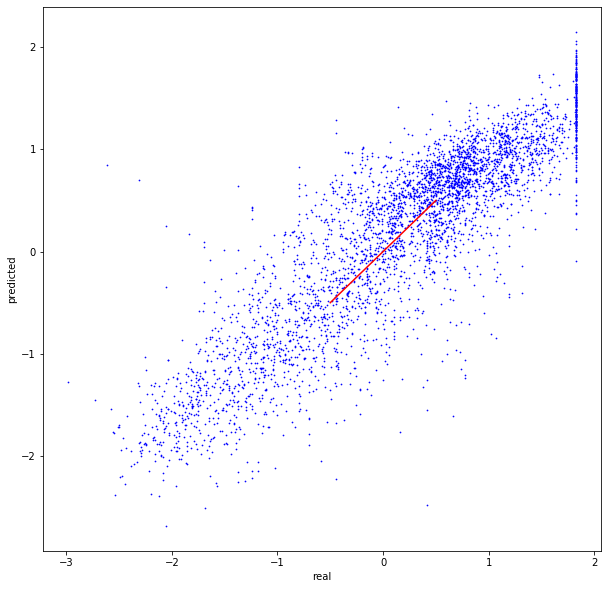

In [85]:
def plot_scatter_predicted(real, predict):
    # set up figure and ax
    fig, ax = plt.subplots(figsize=(10,10))

    # plotting the points as scatter plot 
    ax.scatter(real, predict, color = "blue", s=0.5) 
  
    # plotting the identity function
    ax.plot([-0.50, 0.5], [-0.5, 0.5], color='red')
  
    # putting labels 
    plt.xlabel('real') 
    plt.ylabel('predicted') 
  
    plt.show()


plot_scatter_predicted(y_test, y_predicted)

Text(0, 0.5, 'residual')

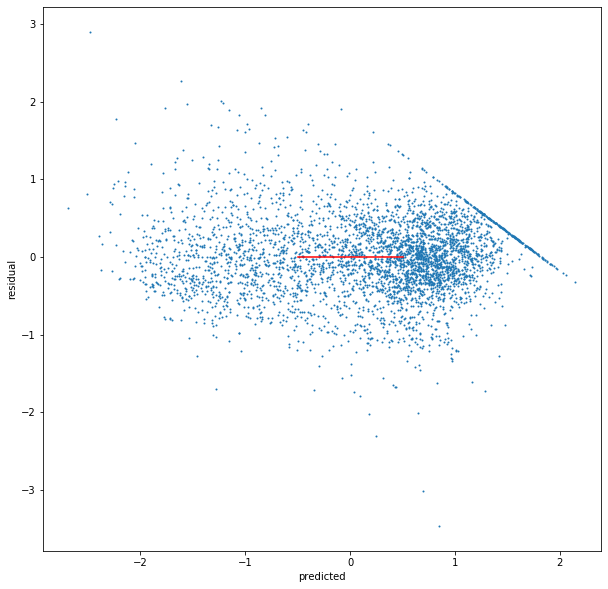

In [86]:
pred_val = y_predicted
true_val = y_test
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(pred_val, residual, s=1)
ax.plot([-0.5, 0.5], [0, 0], color='red')
plt.xlabel('predicted') 
plt.ylabel('residual')

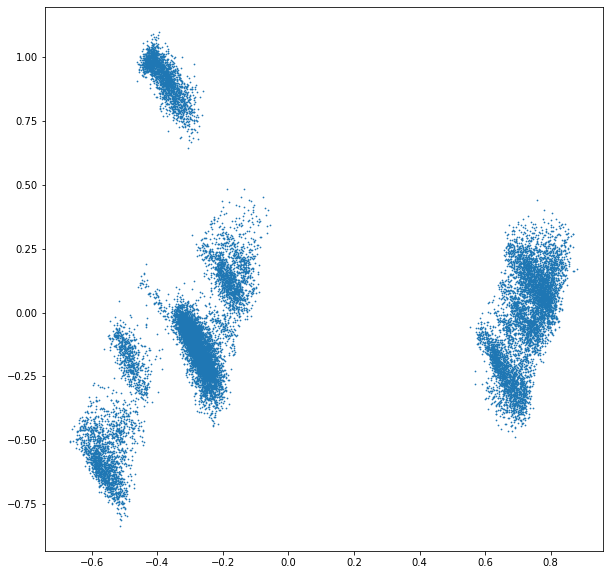

In [18]:
from sklearn.preprocessing import MinMaxScaler

def pca(x:np.ndarray, n_components=2)->np.ndarray:
    return PCA(n_components=n_components).fit_transform(x)

scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(x)


plt.figure(figsize=(10,10))
plt.scatter(*pca(data_rescaled).T, s=0.5)
plt.show()